Dataset Loaded: 8480 files


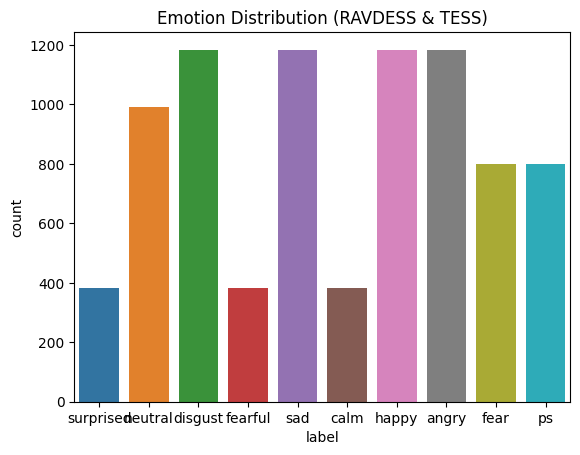

Feature shape: (8480, 100, 40)
Training samples: 6784 | Validation samples: 1696


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         173,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,178 (746.79 KB)

 Trainable params: 190,666 (744.79 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
Epoch 1, Batch 0 details: {'accuracy': 0.140625, 'loss': 2.897092819213867}
  5/106 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.1553 - loss: 2.6655Epoch 1, Batch 5 details: {'accuracy': 0.1875, 'loss': 2.430347204208374}
 10/106 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.1854 - loss: 2.4928Epoch 1, Batch 10 details: {'accuracy': 0.2400568127632141, 'loss': 2.1968958377838135}
 15/106 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.2127 - loss: 2.3616Epoch 1, Batch 15 details: {'accuracy': 0.302734375, 'loss': 1.991615653038025}
 20/106 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.2389 - loss: 2.2543Epoch 1, Batch 20 details: {'accuracy': 0.337797611951828, 'loss': 1.859840750694275}
 25/106 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.2615 - loss: 2.1672Epoch 1, Batch 25 details: {'accuracy': 0.36598557233810425, 'loss': 1.763541340827942}
 30/106 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.2813 - loss: 2.0935Epoch 1, Batch 30 details: {'accurac

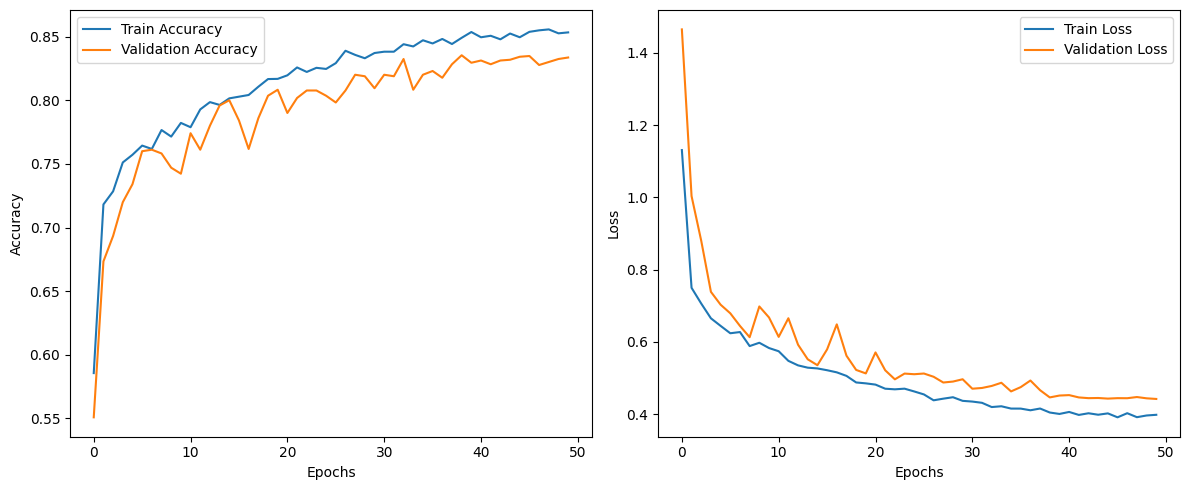

Best Training Accuracy: 85.58%
Best Validation Accuracy: 83.55%


In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

warnings.filterwarnings('ignore')



# -----------------------------
# 1. Load datasets (RAVDESS and TESS) and create DataFrame
# -----------------------------
paths = []
labels = []

# RAVDESS filenames (e.g., "03-01-05-01-02-01-12.wav")
# TESS filenames (e.g., "OAF_angry.wav")
# For RAVDESS, the third segment (index 2) is the emotion code.
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Walk through the input directory and process .wav files from both datasets
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):
            file_path = os.path.join(dirname, filename)
            paths.append(file_path)
            
            # Heuristic: if the filename starts with a digit and contains '-' then assume RAVDESS.
            if filename[0].isdigit() and '-' in filename:
                parts = filename.split('-')
                if len(parts) >= 3:
                    label_code = parts[2]
                    label = emotion_mapping.get(label_code, label_code).lower()
                else:
                    label = filename.split('_')[-1].split('.')[0].lower()
            else:
                # Assume TESS format: label is after the underscore.
                label = filename.split('_')[-1].split('.')[0].lower()
            labels.append(label)

print('Dataset Loaded:', len(paths), 'files')

df = pd.DataFrame({'speech': paths, 'label': labels})
sns.countplot(x=df['label'])
plt.title("Emotion Distribution (RAVDESS & TESS)")
plt.show()

# -----------------------------
# 2. Improved MFCC Feature Extraction Function
# -----------------------------
def extract_mfcc_features(filename, n_mfcc=40, max_len=100):
    """
    Loads an audio file and extracts a fixed-length MFCC feature matrix.
    - n_mfcc: number of MFCCs to extract.
    - max_len: number of time frames to pad/truncate to.
    """
    y, sr = librosa.load(filename, sr=None)
    
    # Optional: Data augmentation (uncomment to use)
    # y = librosa.effects.pitch_shift(y, sr, n_steps=2)
    # y = librosa.effects.time_stretch(y, rate=1.1)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate to ensure fixed number of frames
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    # Normalize MFCC
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    # Transpose to shape: (time_steps, n_mfcc)
    return mfcc.T

# Extract features for all audio files
n_mfcc = 40
max_len = 100  # Adjust this value based on audio duration characteristics
features = df['speech'].apply(lambda x: extract_mfcc_features(x, n_mfcc=n_mfcc, max_len=max_len))
X = np.array(list(features))  # Shape: (num_samples, max_len, n_mfcc)
print("Feature shape:", X.shape)

# -----------------------------
# 3. Encode labels and split data
# -----------------------------
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']]).toarray()

# Explicit train/validation split for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Validation samples:", X_val.shape[0])

# -----------------------------
# 4. Define the LSTM Model (with Bidirectional LSTM)
# -----------------------------
# Define your model architecture
# Define your model architecture
num_classes = y.shape[1]
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False), input_shape=(max_len, n_mfcc)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Define the custom callback
class StepDetailCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        # For every 5 batches, print the training details regardless of the epoch.
        if batch % 5 == 0:
            print(f"Epoch {self.current_epoch}, Batch {batch} details: {logs}")
            
    def on_epoch_begin(self, epoch, logs=None):
        # Store current epoch; epochs are 0-indexed so we add 1.
        self.current_epoch = epoch + 1

# Setup callbacks list
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    StepDetailCallback()  # custom callback for printing details
]



# -----------------------------
# 5. Train the Model with Callbacks
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    shuffle=True
)


# -----------------------------
# 6. Plot Training History
# -----------------------------
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Display best metrics
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Training Accuracy: {best_train_acc * 100:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")


**Testing on Real Interview**

In [10]:
!pip install pygame --upgrade


^C


In [12]:
from moviepy.editor import VideoFileClip
import ipywidgets as widgets
from IPython.display import display, clear_output

In [19]:
def save_uploaded_video(uploader):
    if uploader.value:
        # uploader.value might be a dict or list; try converting to a list of file info objects.
        try:
            # if uploader.value behaves like a dictionary:
            files = list(uploader.value.values())
        except AttributeError:
            # Otherwise, assume uploader.value is already iterable
            files = uploader.value

        for file_info in files:
            # file_info might be a dict or an object with attributes 'name' and 'content'
            if isinstance(file_info, dict):
                fname = file_info.get('name', None)
                content = file_info.get('content', None)
            else:
                fname = getattr(file_info, "name", None)
                content = getattr(file_info, "content", None)
                
            if fname is not None and content is not None:
                with open(fname, "wb") as f:
                    f.write(content)
                print(f"Uploaded video saved as: {fname}")
                return fname
    else:
        print("No file uploaded!")
    return None


In [20]:
# You can run this cell after uploading the file.
video_filename = save_uploaded_video(upload_widget)

Uploaded video saved as: gp test.mp4


In [21]:
import numpy as np
import librosa

def segment_audio(signal, sr, segment_length_sec=6):
    """
    Splits a long audio signal into segments of fixed length.
    
    Parameters:
      signal: The full audio array.
      sr: Sample rate.
      segment_length_sec: Duration of each segment in seconds.
      
    Returns:
      A list of audio segments (numpy arrays).
    """
    samples_per_segment = sr * segment_length_sec
    total_samples = len(signal)
    segments = []
    
    # Iterate over audio with fixed steps (non-overlapping segments)
    for start in range(0, total_samples, samples_per_segment):
        end = start + samples_per_segment
        seg = signal[start:end]
        # If the segment is shorter than the segment length, pad it
        if len(seg) < samples_per_segment:
            pad_width = samples_per_segment - len(seg)
            seg = np.pad(seg, (0, pad_width), mode='constant')
        segments.append(seg)
    return segments


In [22]:
def extract_mfcc_from_signal(signal, sr, n_mfcc=40, max_len=100):
    """
    Extract MFCC features from an audio signal.
    
    Parameters:
      signal: The audio signal array.
      sr: Sample rate.
      n_mfcc: Number of MFCCs.
      max_len: Number of frames to pad/truncate to.
      
    Returns:
      Transposed MFCC feature matrix with shape (time_steps, n_mfcc).
    """
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    return mfcc.T  # Shape: (max_len, n_mfcc)


In [24]:
import librosa

# Load the full audio from the previously extracted file
audio_file = "gp test.mp4"
signal, sr = librosa.load(audio_file, sr=None)
print("Full audio length (seconds):", len(signal) / sr)

# Segment the long audio into 6-second chunks
segments = segment_audio(signal, sr, segment_length_sec=6)
print(f"Total segments created: {len(segments)}")


Full audio length (seconds): 45.16281179138322
Total segments created: 8


In [25]:
n_mfcc = 40
max_len = 100  # Should match your training parameter

# Process every segment to get MFCC features in the expected shape
features = []
for seg in segments:
    mfcc_features = extract_mfcc_from_signal(seg, sr, n_mfcc=n_mfcc, max_len=max_len)
    features.append(mfcc_features)

# Convert the list to a numpy array with shape (num_segments, max_len, n_mfcc)
X_test = np.array(features)
print("Shape of X_test:", X_test.shape)


Shape of X_test: (8, 100, 40)


In [28]:
# Predict on all segments (X_test shape is: (num_segments, max_len, n_mfcc))
predictions = model.predict(X_test)  # shape: (num_segments, num_classes)
print("Predictions for each segment:\n", predictions)

# Option 1: Average softmax probabilities across all segments
avg_predictions = np.mean(predictions, axis=0)
overall_index = np.argmax(avg_predictions)
print("Averaged prediction scores:", avg_predictions)



# Option 2: Alternatively, you could also perform a majority vote on each segment's prediction:
segment_labels = np.argmax(predictions, axis=1)
from scipy.stats import mode
majority_vote_result = mode(segment_labels)
# Check if the mode is an array or scalar:
if np.isscalar(majority_vote_result.mode):
    majority_vote_index = majority_vote_result.mode
else:
    majority_vote_index = majority_vote_result.mode[0]

if 'enc' in globals():
    majority_emotion = enc.categories_[0][majority_vote_index]
    print("Overall predicted emotion (majority vote):", majority_emotion)
else:
    print("OneHotEncoder 'enc' not found.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predictions for each segment:
 [[1.5367848e-04 7.1123195e-06 6.2778154e-03 9.0330437e-02 7.3460219e-06
  9.0196925e-01 5.5135088e-06 1.8669575e-09 1.2479480e-03 9.4472654e-07]
 [9.9235725e-01 1.5200715e-08 6.0052699e-03 3.0785954e-10 7.5490949e-05
  1.5354772e-03 2.5345622e-05 4.5559576e-17 1.1549888e-06 8.3115822e-08]
 [8.6782011e-06 1.2839924e-02 9.5947653e-01 1.5022369e-05 4.8905764e-07
  1.3102881e-03 5.8282109e-05 1.7173604e-10 2.6285626e-02 5.1669981e-06]
 [9.7110955e-05 1.9694701e-01 1.0883481e-01 2.9177971e-05 9.2763257e-06
  9.2887820e-04 9.7171001e-02 4.6044906e-13 5.9598267e-01 6.5324947e-08]
 [1.8503830e-06 8.9386531e-06 2.3189602e-04 2.9036579e-08 4.3406732e-07
  1.2673095e-05 2.4319455e-05 6.3852749e-15 9.9971986e-01 1.2360623e-09]
 [1.5977473e-03 1.3326739e-04 9.5481455e-01 9.7381644e-07 2.9314028e-06
  4.0885184e-02 5.6900480e-04 2.5362697e-15 1.9963712e-03 5.6945444e-09]
 [2.5023692e-05 3.3228058e-02 1.8147333e-01 2.7868461e-09 2.1

In [30]:
import ipywidgets as widgets
from IPython.display import display

# Create an audio file uploader widget that accepts WAV and MP3 files.
audio_upload_widget = widgets.FileUpload(
    accept=".wav, .mp3",  # Accept only WAV and MP3 files
    multiple=False        # Only one file at a time
)
display(audio_upload_widget)

# Function to save the uploaded audio file to disk
def save_uploaded_audio(uploader):
    if uploader.value:
        try:
            # uploader.value might be a dictionary or a list; convert to a list of file info objects.
            files = list(uploader.value.values())
        except AttributeError:
            files = uploader.value
            
        for file_info in files:
            # Handle both dict and object types (if using Bunch objects in Kaggle)
            if isinstance(file_info, dict):
                fname = file_info.get('name', None)
                content = file_info.get('content', None)
            else:
                fname = getattr(file_info, "name", None)
                content = getattr(file_info, "content", None)
                
            if fname is not None and content is not None:
                with open(fname, "wb") as f:
                    f.write(content)
                print(f"Uploaded audio saved as: {fname}")
                return fname
    else:
        print("No audio file uploaded!")
    return None


FileUpload(value=(), accept='.wav, .mp3', description='Upload')

In [31]:
# Save the uploaded audio file and get its filename
audio_filename = save_uploaded_audio(audio_upload_widget)

Uploaded audio saved as: WhatsApp-Audio-2025-04-08-at-18.49.41_cd1cfcf9.waptt.mp3


In [32]:
import numpy as np
import librosa

def segment_audio(signal, sr, segment_length_sec=6):
    """
    Splits a long audio signal into segments of fixed length.
    
    Parameters:
      signal: The full audio array.
      sr: Sample rate.
      segment_length_sec: Duration of each segment in seconds.
      
    Returns:
      A list of audio segments (numpy arrays).
    """
    samples_per_segment = sr * segment_length_sec
    total_samples = len(signal)
    segments = []
    
    # Iterate over audio with fixed steps (non-overlapping segments)
    for start in range(0, total_samples, samples_per_segment):
        end = start + samples_per_segment
        seg = signal[start:end]
        # If the segment is shorter than the segment length, pad it
        if len(seg) < samples_per_segment:
            pad_width = samples_per_segment - len(seg)
            seg = np.pad(seg, (0, pad_width), mode='constant')
        segments.append(seg)
    return segments


def extract_mfcc_from_signal(signal, sr, n_mfcc=40, max_len=100):
    """
    Extract MFCC features from an audio signal.
    
    Parameters:
      signal: The audio signal array.
      sr: Sample rate.
      n_mfcc: Number of MFCCs.
      max_len: Number of frames to pad/truncate to.
      
    Returns:
      Transposed MFCC feature matrix with shape (time_steps, n_mfcc).
    """
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    return mfcc.T  # Shape: (max_len, n_mfcc)
import librosa

# Load the full audio from the previously extracted file
audio_file = "WhatsApp-Audio-2025-04-08-at-18.49.41_cd1cfcf9.waptt.mp3"
signal, sr = librosa.load(audio_file, sr=None)
print("Full audio length (seconds):", len(signal) / sr)

# Segment the long audio into 6-second chunks
segments = segment_audio(signal, sr, segment_length_sec=6)
print(f"Total segments created: {len(segments)}")
n_mfcc = 40
max_len = 100  # Should match your training parameter

# Process every segment to get MFCC features in the expected shape
features = []
for seg in segments:
    mfcc_features = extract_mfcc_from_signal(seg, sr, n_mfcc=n_mfcc, max_len=max_len)
    features.append(mfcc_features)

# Convert the list to a numpy array with shape (num_segments, max_len, n_mfcc)
X_test = np.array(features)
print("Shape of X_test:", X_test.shape)



Full audio length (seconds): 3.817833333333333
Total segments created: 1
Shape of X_test: (1, 100, 40)


In [33]:
# Predict on all segments (X_test shape is: (num_segments, max_len, n_mfcc))
predictions = model.predict(X_test)  # shape: (num_segments, num_classes)
print("Predictions for each segment:\n", predictions)

# Option 1: Average softmax probabilities across all segments
avg_predictions = np.mean(predictions, axis=0)
overall_index = np.argmax(avg_predictions)
print("Averaged prediction scores:", avg_predictions)



# Option 2: Alternatively, you could also perform a majority vote on each segment's prediction:
segment_labels = np.argmax(predictions, axis=1)
from scipy.stats import mode
majority_vote_result = mode(segment_labels)
# Check if the mode is an array or scalar:
if np.isscalar(majority_vote_result.mode):
    majority_vote_index = majority_vote_result.mode
else:
    majority_vote_index = majority_vote_result.mode[0]

if 'enc' in globals():
    majority_emotion = enc.categories_[0][majority_vote_index]
    print("Overall predicted emotion (majority vote):", majority_emotion)
else:
    print("OneHotEncoder 'enc' not found.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Predictions for each segment:
 [[7.1512698e-04 2.3418188e-01 1.2380660e-04 3.1962757e-06 1.1250943e-05
  2.0028888e-04 6.8201429e-01 3.5199070e-09 6.4835481e-02 1.7914712e-02]]
Averaged prediction scores: [7.1512698e-04 2.3418188e-01 1.2380660e-04 3.1962757e-06 1.1250943e-05
 2.0028888e-04 6.8201429e-01 3.5199070e-09 6.4835481e-02 1.7914712e-02]
Overall predicted emotion (majority vote): neutral
